# Pipeline de demonstração do EA‑VRP.

Gera dados sintéticos (passageiros, veículos, pontos de recarga), executa o
agrupamento geográfico e imprime no console a composição de cada grupo.

Uso
---
```
$ docker compose up 
```

## Bibliotecas

In [1]:
import random
from typing import List

import numpy as np
import pandas as pd

from geografics import generate_random_geografic_points
from grouping import GeoGrouper, EAVRPGroup
from utils import Passenger, Vehicle, RechargePoint, Depot
from encoder import QUBOEncoder
from solver import QAOASolver
from graph import build_graph

from pathlib import Path

## Parâmetros
Quantidade de 
- Passageiros
- Veículos
- Pontos de recargas
- Depósitos (ponto para saída e retorno de veículos)

In [2]:
OUTDIR = Path("figs")
OUTDIR.mkdir(parents=True, exist_ok=True)

seed = 42
filename_hist = OUTDIR / "teste_histograma.png" # nome do arquivo do histograma
filename_graph = OUTDIR / "teste_grafo.png" # nome do arquivo do grafo

n_passengers = 5
n_vehicles = 3
n_recharge_points = 1
n_depots = 1

In [3]:
p=2
shots=1000
steps=15
diameter = 0.2 # 1 => 100km 
shrink_epsilon = 0.9 # None

## Helpers de geração sintética

In [4]:
from feasible_instance_generator import InstanceGenerator as Generator

generator = Generator(
    n_passengers,
    n_vehicles,
    n_depots,
    n_recharge_points,
    seed=seed
)

vehicles, passengers, depot, recharge_points  = generator.build()

## Agrupamento de Passageiros

In [5]:
grouper = GeoGrouper(delta=diameter)
groups = grouper.fit(passengers)

for g in groups:
    p_ids = [passenger.id for passenger in g.passengers]
    print(f"Grupo {g.id:02d} | {len(p_ids)} passageiros -> {p_ids}")

total_qubits = len(groups)  # variável por grupo (modelo futuro)
print(f"Total de grupos (≈ qubits na formulação): {total_qubits}")

Grupo 01 | 5 passageiros -> ['1', '2', '3', '5', '4']
Total de grupos (≈ qubits na formulação): 1


## Construção do QUBO

In [6]:
# QUBO para somente grupos sem compressão
encoder = QUBOEncoder(vehicles, 
                             groups, 
                             recharge_points,
                             depot=depot
                            )
encoder_passengers = QUBOEncoder(vehicles, 
                             passengers, 
                             recharge_points, 
                             depot=depot
                            )

In [7]:
print(f"Quantidade de qubits com grupos: {encoder.num_qubits}")
print(f"Quantidade de qubits sem grupos: {encoder_passengers.num_qubits}")

Quantidade de qubits com grupos: 6
Quantidade de qubits sem grupos: 18


In [8]:
print("Matriz QUBO (valores arredondados a 2 casas decimais):")
encoder.print_matrix(precision=2)

Matriz QUBO (valores arredondados a 2 casas decimais):
[[-1.93  0.    2.    0.    2.    0.  ]
 [ 0.    0.03  0.    0.    0.    0.  ]
 [ 2.    0.   -1.93  0.    2.    0.  ]
 [ 0.    0.    0.    0.03  0.    0.  ]
 [ 2.    0.    2.    0.   -1.93  0.  ]
 [ 0.    0.    0.    0.    0.    0.03]]


In [9]:
print("Matriz QUBO Somente passageiros (valores arredondados a 2 casas decimais):")
encoder_passengers.print_matrix(precision=2)

Matriz QUBO Somente passageiros (valores arredondados a 2 casas decimais):
[[-1.96  2.    2.    2.    2.    0.    2.    0.    0.    0.    0.    0.
   2.    0.    0.    0.    0.    0.  ]
 [ 2.   -1.96  2.    2.    2.    0.    0.    2.    0.    0.    0.    0.
   0.    2.    0.    0.    0.    0.  ]
 [ 2.    2.   -1.96  2.    2.    0.    0.    0.    2.    0.    0.    0.
   0.    0.    2.    0.    0.    0.  ]
 [ 2.    2.    2.   -1.98  2.    0.    0.    0.    0.    2.    0.    0.
   0.    0.    0.    2.    0.    0.  ]
 [ 2.    2.    2.    2.   -1.97  0.    0.    0.    0.    0.    2.    0.
   0.    0.    0.    0.    2.    0.  ]
 [ 0.    0.    0.    0.    0.    0.03  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.  ]
 [ 2.    0.    0.    0.    0.    0.   -1.96  2.    2.    2.    2.    0.
   2.    0.    0.    0.    0.    0.  ]
 [ 0.    2.    0.    0.    0.    0.    2.   -1.96  2.    2.    2.    0.
   0.    2.    0.    0.    0.    0.  ]
 [ 0.    0.    2.    0.    0.    0.  

In [10]:
print(f"Offset com compressão (constante): {encoder.offset:.2f}")

Offset com compressão (constante): 4.00


## Otimização pelo algoritmo QAOA

In [11]:
# 3) QAOA 
solver = QAOASolver(encoder,
                    p=p,
                    shots=shots,
                    steps=steps,
                    dev="lightning.qubit", # "default.qubit"
                    seed=seed)
# best_bits, best_cost = solver.solve()

results = solver.solve()
best_bits = results.best_bits
best_cost = results.best_cost


/opt/conda/lib/python3.11/site-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


In [12]:
# Estado inteiro x (LSB = qubit 0)
x_val = int("".join(map(str, best_bits[::-1])), 2)
print(f"Bitstring: {best_bits} => Melhor estado: |{x_val}⟩  ==> custo {best_cost:.2f}\n")

Bitstring: [1, 0, 0, 0, 0, 0] => Melhor estado: |1⟩  ==> custo 2.07



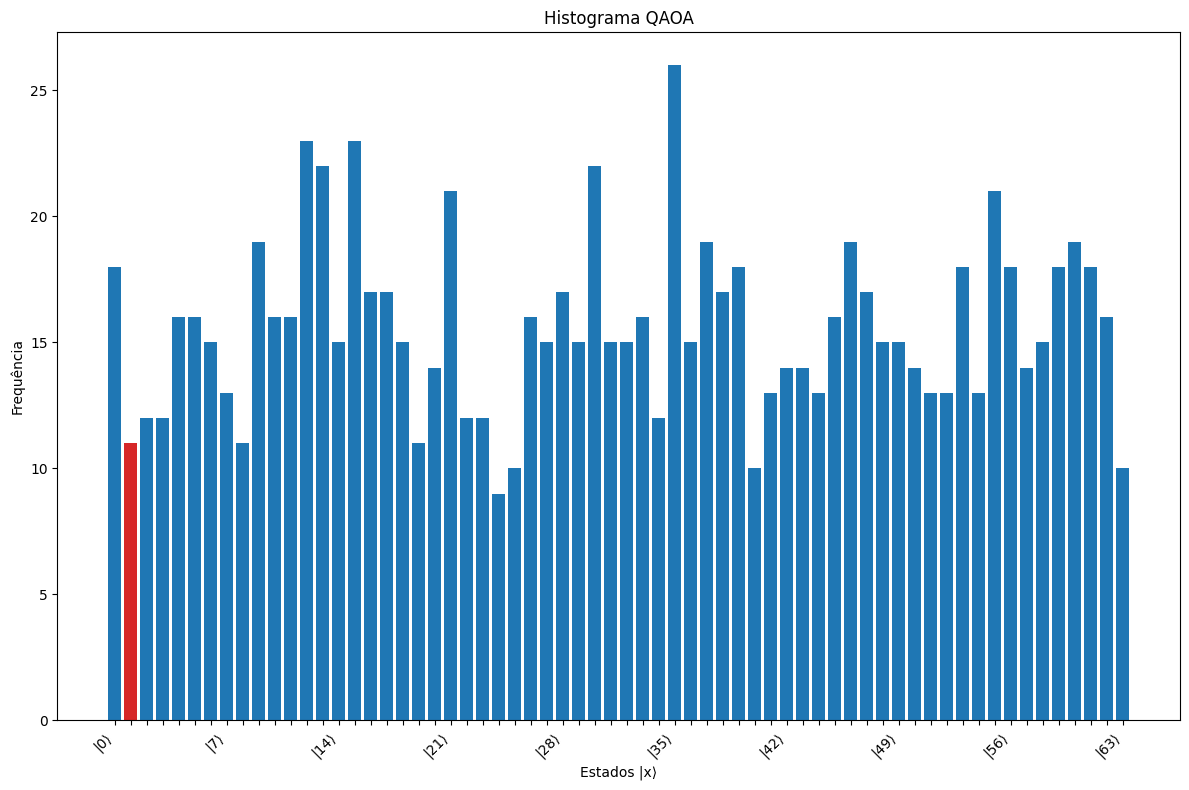

Histograma salvo em: figs/teste_histograma.png


In [13]:
# 4) Histograma
solver.plot_histogram(filename_hist)
print(f"Histograma salvo em: {filename_hist}")

## Grafo do VRP

(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)
(-23.685627021200144, -46.55)


/home/jovyan/work/graph.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


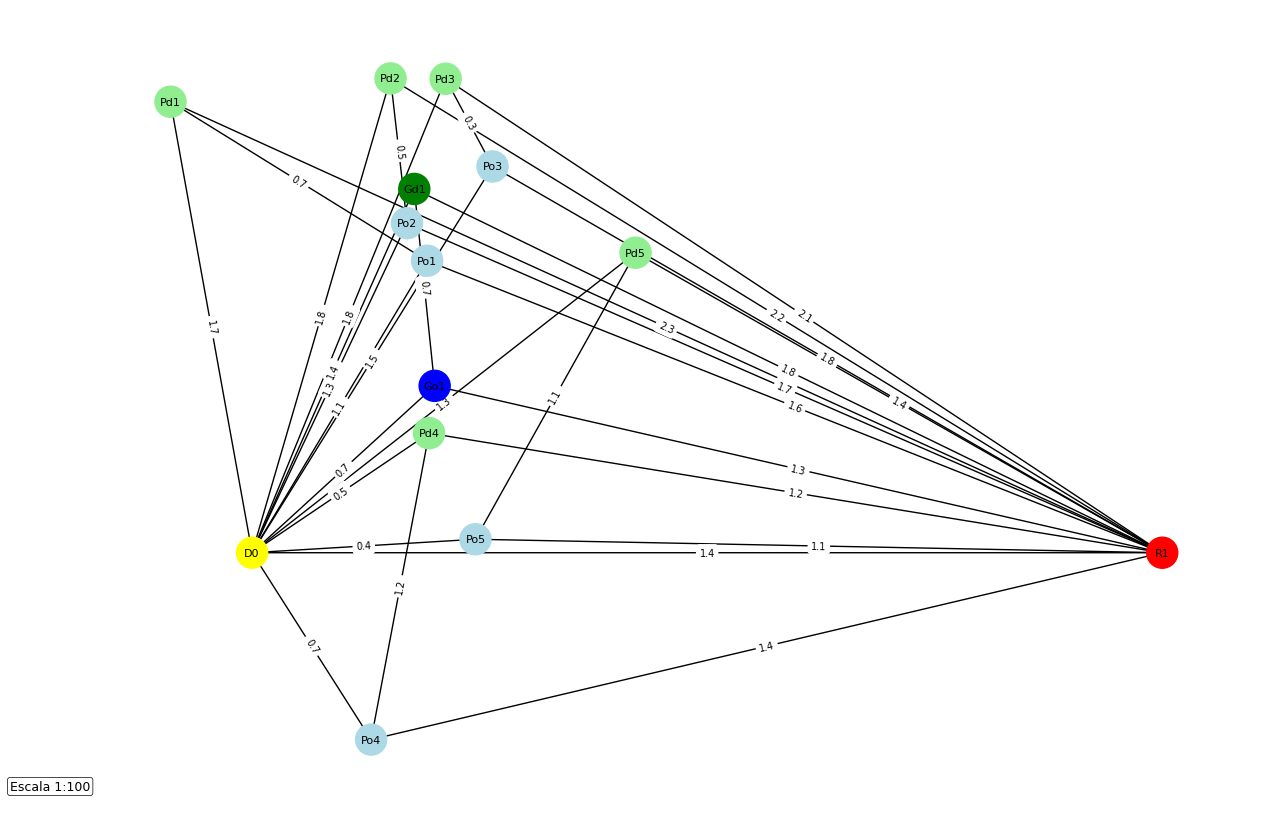

Grafo salvo em: figs/teste_grafo.png


In [14]:
build_graph(passengers, groups, recharge_points, depot, filename_graph)
print(f"Grafo salvo em: {filename_graph}")

# Solução por método Clássico

Busca de rotas resolvidas para pequenas instâncias de EA-VRP *sem* hardware quântico. A classe abaixo reutiliza o QUBO que o `QUBOEncoder` já constrói e o alimenta em um solucionador exato **clássico** (`dimod.ExactSolver`). Como a busca é exaustiva, ela é prática apenas para exemplos toy model (máximo de 25 a 30 variáveis binárias), mas é totalmente determinística e produz o ótimo global.

In [15]:
from classical_solver import ClassicalVRPSolver

In [16]:
# cell 3
encoder = QUBOEncoder(
    vehicles,
    groups,
    recharge_points,
    depot=depot,
    penalty_lambda=5.0,   # penaliza violar "um grupo = 1 veículo"
    penalty_mu=2.0        # penaliza exceder capacidade
)

solver = ClassicalVRPSolver(encoder)


In [17]:
# cell 4
solver.solve()                 # leva milissegundos nesta instância
best = solver.best()
best

{'bits': '000010',
 'energy': 4.074095763754355,
 'feasible': False,
 'cost': nan,
 'routes': None}

In [18]:
# cell 5
top = pd.DataFrame(solver.k_best(k=10))
top

,bits,energy,feasible,cost
0,000010,4.074096,False,NaN
1,001000,4.074096,True,NaN
2,100000,4.074096,True,NaN
3,000011,4.102842,False,NaN
4,000110,4.102842,False,NaN
5,001001,4.102842,True,NaN
6,001100,4.102842,True,NaN
7,010010,4.102842,True,NaN
8,011000,4.102842,False,NaN
9,100001,4.102842,True,NaN


## Calibração de $\mu$ e $\lambda$

Implementação de busca em escala logarítma para avaliar cada par $(\lambda,\mu)$ métricas como:
- Taxa da factibilidade
- Energia Média
- Custo ótimo encontrado

In [19]:
# 1) Lista de valores para escanear 
exps = [2, 3, 4, 5, 6]
lambdas = [10**e for e in exps]
mus     = [10**e for e in exps]

# 2) Função para avaliar um par (λ, μ)
def evaluate_lambda_mu(lambda_, mu):
    # 2.1) Gere QUBO com estes parâmetros
    encoder.set_penalties(lambda_=lambda_, mu=mu)
    Q, offset, _ = encoder.encode()

    # 2.2) Monte e rode o solver (QAOA simples)
    solver = QAOASolver(encoder=encoder,
                        p=5,           # profundidade baixa para teste rápido
                        # dev='default.qubit',
                        shots=7000, #shots,
                        seed=42,
                       )
    result = solver.solve()

    Result = {
        'lambda': lambda_,
        'mu': mu,
        'feas_rate': result.feas_rate,
        'avg_energy': result.avg_energy,
        'best_cost': result.best_cost,
        'best_bitstring': result.best_bits,
    }

    # 2.3) Retorno das métricas
    return Result

# 3) Loop de calibração
results = []
for lam in lambdas:
    for mu in mus:
        metrics = evaluate_lambda_mu(lam, mu)
        print(f"λ={lam}, μ={mu} → factível: {metrics['feas_rate']:.2f}, "
              f"E_avg={metrics['avg_energy']:.2f}, C_best={metrics['best_cost']:.2f}, "
              f"Best Bitstring: {metrics['best_bitstring']}, "
        )
        results.append(metrics)

# 4) Analisar resultados
# Exemplo: filtrar apenas casos com fact_rate == 1.0 e escolher o (λ,μ) com menor avg_energy
feas_full = [r for r in results if r['feas_rate'] >= 0.5]
best = min(feas_full, key=lambda r: r['avg_energy'])
print("Melhor configuração:", best)


/opt/conda/lib/python3.11/site-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


λ=100, μ=100 → factível: 0.38, E_avg=386.04, C_best=200.07, Best Bitstring: [0, 0, 1, 0, 0, 0], 
λ=100, μ=1000 → factível: 0.38, E_avg=1756.51, C_best=1000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=100, μ=10000 → factível: 0.37, E_avg=15538.64, C_best=1000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=100, μ=100000 → factível: 0.38, E_avg=153366.77, C_best=1000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=100, μ=1000000 → factível: 0.38, E_avg=1517953.81, C_best=1000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=1000, μ=100 → factível: 0.37, E_avg=2723.03, C_best=200.07, Best Bitstring: [0, 0, 1, 0, 0, 0], 
λ=1000, μ=1000 → factível: 0.37, E_avg=4042.44, C_best=2000.07, Best Bitstring: [0, 0, 1, 0, 0, 0], 
λ=1000, μ=10000 → factível: 0.38, E_avg=17742.29, C_best=10000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=1000, μ=100000 → factível: 0.37, E_avg=153399.73, C_best=10000.22, Best Bitstring: [1, 0, 1, 0, 1, 0], 
λ=1000, μ=1000000 → factível: 0.37, E_avg=1503012.01, C_best=10000.22, Best Bitst

ValueError: min() arg is an empty sequence